In [1]:
import pandas as pd
import numpy as np
import pickle
import re

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go

In [2]:
data = pd.read_pickle(r'/home/khinevich/myproject/hatka/parser/data/DATA.pkl')

In [3]:
data['text'] = data.text + '---' + data.note

In [4]:
def parsing_price(text):
    if text:
        return int(re.sub(pattern=r'\D', string=text, repl=''))
    return -1
data.price = data.price.map(parsing_price)

## Price with len(text)

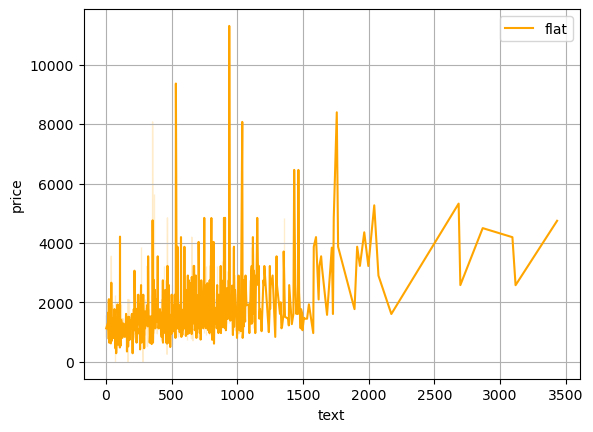

In [233]:
# sns.lineplot(x=range(1, 10_000), y=range(1, 10_000), color='blue', label='line');
sns.lineplot(y=data.price, x=data.text.map(len), color='orange', label='flat');

plt.legend();
plt.grid()
plt.show();

## Добавим слова

Список уникальных слов в каждом описании объявления

In [6]:
def parsing_uniq_words(text: str) -> list:
    text = text.lower()
    text = re.sub(string=text, pattern=r'[^а-яА-Я]', repl=' ')
    words = set(text.split(' ')) - {'', ' '}
    return list(words)

In [7]:
data['words'] = data.text.map(parsing_uniq_words)

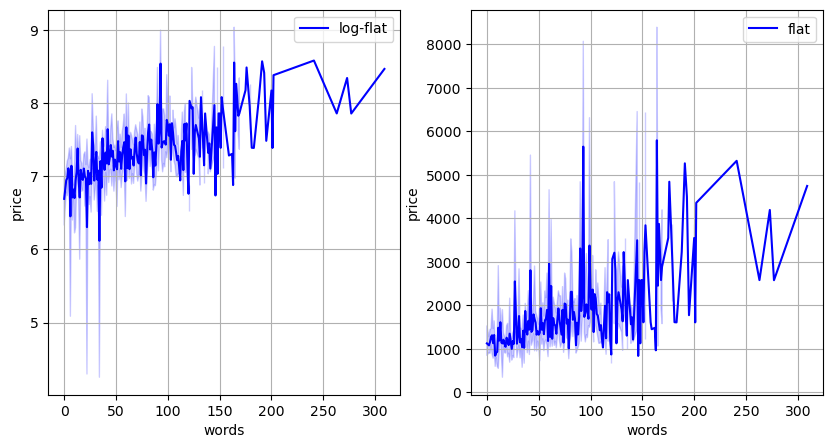

In [8]:
_, axs = plt.subplots(1, 2, figsize=(10, 5),)
sns.lineplot(y=np.log1p(data.price + 2), x=data.words.map(len), color='blue', label='log-flat', ax=axs[0]);
sns.lineplot(y=data.price, x=data.words.map(len), color='blue', label='flat', ax=axs[1]);
axs[0].grid();
axs[1].grid();

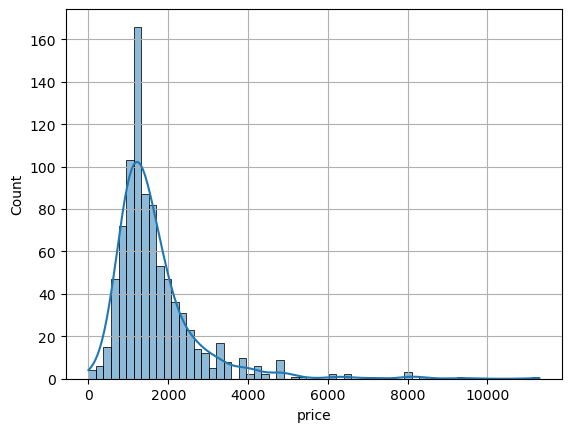

In [9]:
sns.histplot(x=data.price, kde=True)
plt.grid();

In [10]:
def parsing_agent(text: str):
    text = text.lower()
    if 'агент' in text:
        return 1
    return 0

data['is_agent'] = data.owners.map(parsing_agent)

In [11]:
data.is_agent.value_counts()

0    452
1    418
Name: is_agent, dtype: int64

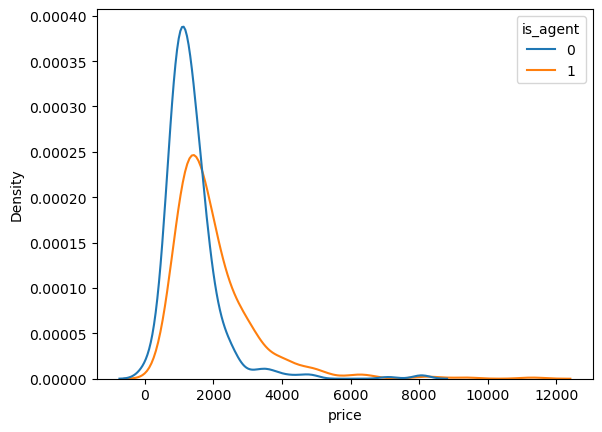

In [12]:
sns.kdeplot(x=data.price, hue=data.is_agent);

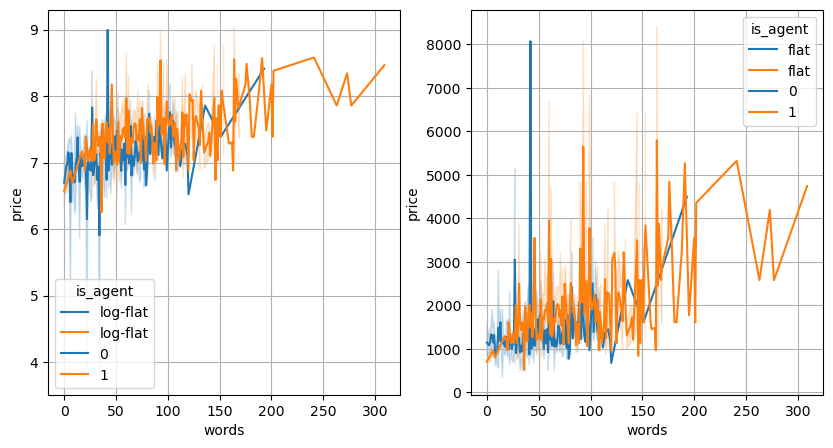

In [103]:
_, axs = plt.subplots(1, 2, figsize=(10, 5),)
sns.lineplot(y=np.log1p(data.price + 2), x=data.words.map(len), color='blue', label='log-flat', ax=axs[0], hue=data.is_agent);
sns.lineplot(y=data.price, x=data.words.map(len), color='blue', label='flat', ax=axs[1], hue=data.is_agent);
axs[0].grid();
axs[1].grid();

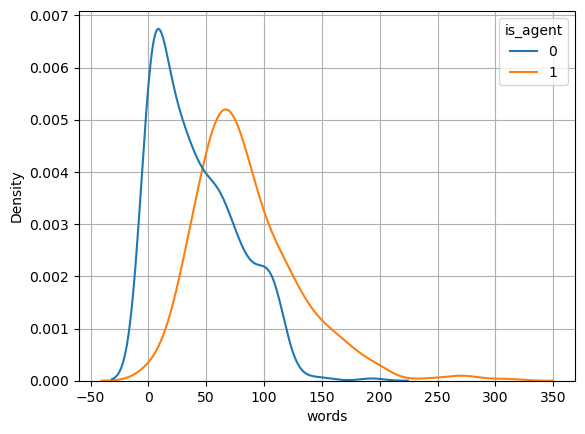

In [231]:
sns.kdeplot(x=data.words.map(len), hue=data.is_agent)
plt.grid();

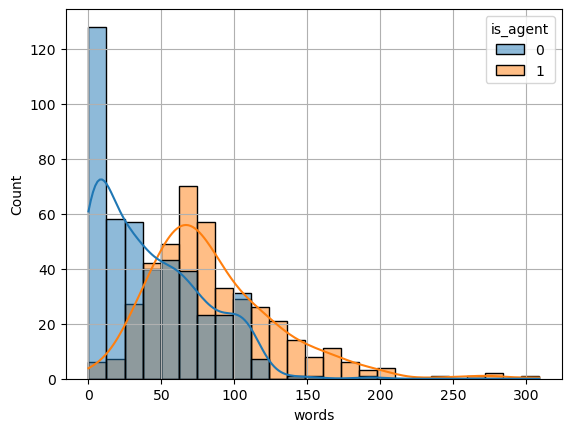

In [105]:
sns.histplot(x=data.words.map(len), hue=data.is_agent, kde=True)
plt.grid();

In [20]:
drop_words4adress = ["ул", "просп", "просп.", 'ул.', 'область', 'пер.', "тракт"]

In [21]:
def parsing_adres(text: str):
    for w in drop_words4adress:
        text = re.sub(pattern=w, repl=f' {w} ', string=text)
    return text
data.adres = data.adres.map(parsing_adres)

In [94]:
def parser_city(text):
    text = text.lower()
    searched = re.search(pattern=r'г\.(.|\s|\xa0)+[а-я]+\s', string=text)
    if searched:
        return searched.group()
    return None

In [95]:
re.search(pattern=r'г\..+[а-я]\s', string='г. минск     ул. . . игоря').group()

'г. минск '

In [96]:
data['city'] = data.adres.map(parser_city)

In [107]:
map_params = {'Балкон': 'balkon',
 'Гараж': 'garage',
 'Год постройки': 'bild_date',
 'Квартплата': 'salce',
 'Количество комнат': 'count_room',
 'Мебель': 'mebel',
 'Планировка': 'palerovka',
 'Площадь жилая': 'ploschad',
 'Площадь общая': 'ploschad_all',
 'Раздельных комнат': 'rooms',
 'Ремонт': 'remonts',
 'Санузел': 'sanuzel',
 'Срок аренды': 'sroc',
 'Этажность': 'etaginosti'}

In [110]:
def parser_params(params: dict, index: str) -> pd.DataFrame:
    new_params = {}
    for k in map_params.keys():
        new_k = map_params[k]
        if k in params:
            if new_k not in new_params:
                new_params[new_k] = [params[k]]
            else:
                raise Exception
        else:
            new_params[new_k] = [None]
    return pd.DataFrame(new_params, index=[index])

params_dt = pd.concat([
    parser_params(
        data.iloc[i].params,
        data.iloc[i].name) for i in range(data.shape[0])
])
params_dt

,balkon,garage,bild_date,salce,count_room,mebel,palerovka,ploschad,ploschad_all,rooms,remonts,sanuzel,sroc,etaginosti
0,Лоджия,Есть,2014,100%,3,Есть,Новостройка,56 м²,90 м²,2,Евроремонт,Раздельный,Длительный,9
1,Балкон,None,1946,100%,4,Есть,Сталинка,80 м²,120 м²,3,Отличный,2 и более,Длительный,None
2,Лоджия,None,None,100%,1,Есть,None,34.1 м²,40.1 м²,1,Евроремонт,Совмещенный,Длительный,None
3,Лоджия застекленная,None,1998,Нет,3,Есть,Новостройка,56.7 м²,105.1 м²,3,None,Раздельный,Длительный,None
4,Лоджия застекленная,None,2017,100%,2,Есть,Новостройка,30 м²,55 м²,2,Отличный,Совмещенный,Длительный,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,Лоджия,None,1972,100%,2,Есть,Улучшенный проект,31 м²,50 м²,2,Хороший,Раздельный,Длительный,None
866,Лоджия,None,2017,50%,1,Есть,Новостройка,30 м²,34.9 м²,1,Евроремонт,Совмещенный,Длительный,None
867,Лоджия застекленная,None,1971,Нет,1,Есть,Брежневка,17 м²,35 м²,1,None,Раздельный,Длительный,None
868,Лоджия застекленная,None,2021,100%,2,Есть,Новостройка,42 м²,45 м²,2,Отличный,Совмещенный,Длительный,None


In [114]:
data = pd.merge(data, params_dt, left_index=True, right_index=True, how='inner')

In [118]:
data.count_room.value_counts()

2    357
1    237
3    226
4     39
5     10
6      1
Name: count_room, dtype: int64

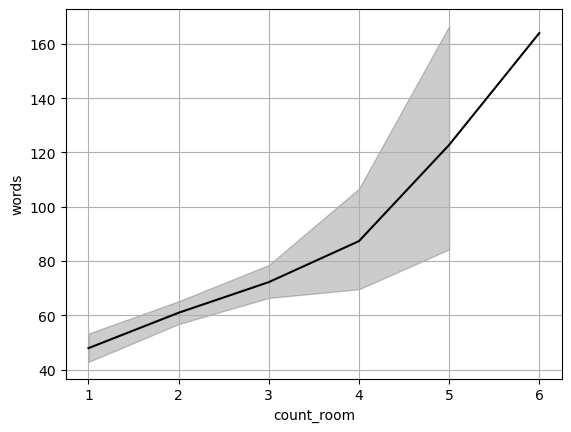

In [130]:
sns.lineplot(y=data.words.map(len), x=data.count_room.astype(int), color='black')
plt.grid();

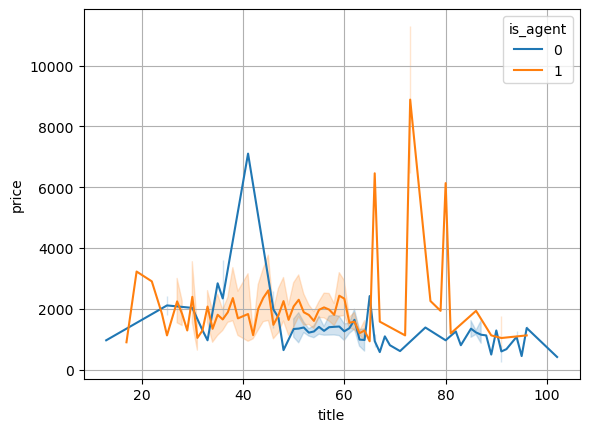

In [139]:
sns.lineplot(
    y=data.price,
    x=data.title.map(lambda x: len(x) if x else 0),
    hue=data.is_agent
)
plt.grid();

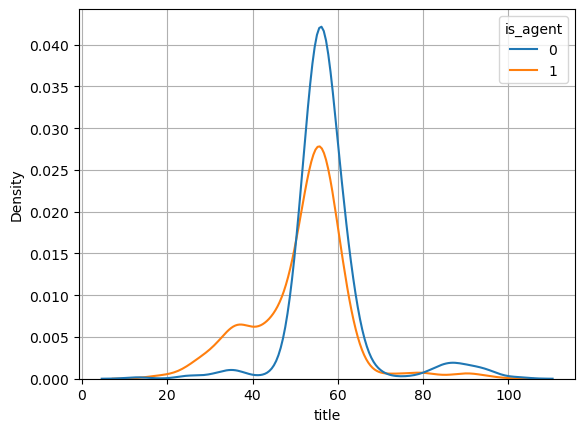

In [136]:
sns.kdeplot(
    x=data.title.map(lambda x: len(x) if x else 0),
    hue=data.is_agent,
)
plt.grid();

In [149]:
data.bild_date = data.bild_date.map(lambda x: int(x) if x else 2020)

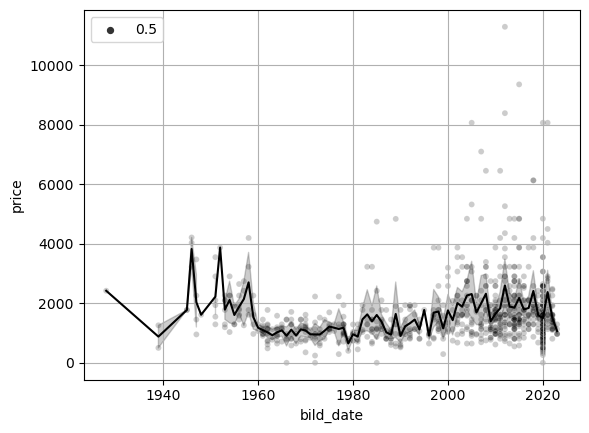

In [168]:
sns.scatterplot(y=data.price, x=data.bild_date, alpha=0.2, color='black', size=0.5)
sns.lineplot(y=data.price, x=data.bild_date, color='black')
plt.grid();

In [177]:
agent_words = [w for words in data[data.is_agent == 1].words.values for w in words if len(w) > 2]

In [179]:
pd.value_counts(agent_words)

больше           406
квартира         391
показать         355
для              321
договор          195
                ... 
инверторный        1
аттракционами      1
двориком           1
стул               1
брежневке          1
Length: 4243, dtype: int64

In [226]:
def clear_text(text: str) -> str:
    text = text.lower()
    # DOT
    text = re.sub(pattern=r'\.', string=text, repl=' ')
    # Comma
    text = re.sub(pattern=r'_', repl=' ', string=text)
    text = re.sub(pattern=r'\,', string=text, repl=' ')
    text = re.sub(pattern=r'\W', string=text, repl=' ')
    text = re.sub(pattern='\d+',repl=' ', string=text)
    text = re.sub(pattern=r'[a-z]+', repl=' ', string=text)

    # text = re.sub(pattern='\d+',repl='', string=text)
    text = ' '.join([i for i in text.split(' ') if (len(i) > 1 and i not in ['', ' '])])
    # text = "POS " + text + " POS"
    return text

In [227]:
data['clear_text'] = data.text.map(clear_text)

In [228]:
data.clear_text

0      уникальная квартира притягивающая своим качест...
1      представителям дипломатического корпуса возмож...
2      сдается квартира студия новом элитном доме цен...
3      аренда комнатной квартиры минск пр машерова об...
4      сдам квартиру как на длительный так на коротки...
                             ...                        
865    квартира обустроенна тихом месте центрального ...
866            аэродромная минутковальская слобода минут
867    комнатная квартира тихом центре по адресу минс...
868    квартира новом доме есть вся необходимая техни...
869    сдаётся абсолютно новая двухкомнатная квартира...
Name: clear_text, Length: 870, dtype: object

In [229]:
text_tfidf_vectorizer = TfidfVectorizer()
text_tfidf_matrix = text_tfidf_vectorizer.fit_transform(data.clear_text)

terms = text_tfidf_vectorizer.get_feature_names_out()
text_tfidf_df = pd.DataFrame(data=text_tfidf_matrix.toarray(), columns=terms)
text_tfidf_df.index = data.index
text_tfidf_df

,абонемент,абонентской,аботы,абсолютно,авакяна,августа,аврора,авроровская,австрии,австрийских,...,янаконтактное,январе,января,яндекс,янки,ярких,ясеня,ясна,ятоба,ёх
0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
866,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
867,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
868,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


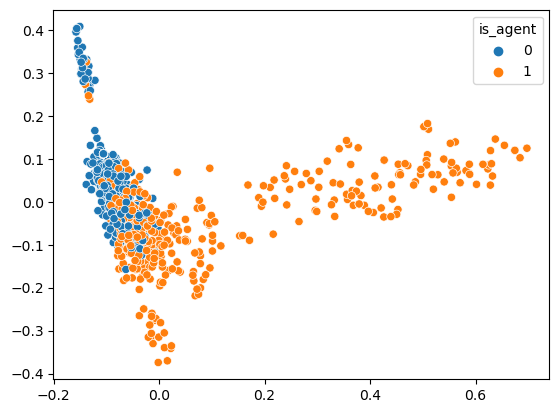

In [230]:
pca = PCA(n_components=2)
Xpca_text = pca.fit_transform(text_tfidf_df.values)

sns.scatterplot(x=Xpca_text[:, 0], y=Xpca_text[:, 1], hue=data.is_agent);

In [234]:
data

,index,href,title,text,note,adres,price,params,owners,conveniences,...,mebel,palerovka,ploschad,ploschad_all,rooms,remonts,sanuzel,sroc,etaginosti,clear_text
0,1487954,https://realt.by/rent-flat-for-long/object/148...,Уютная трехкомнатная квартира в современном жи...,"Уникальная квартира, притягивающая своим качес...",,"г. Минск просп. . . Победителей, 125",4844,"{'Количество комнат': '3', 'Раздельных комнат'...","ООО ""Твоя столица""Агентство недвижимостиЛицен...","[Холодильник, СВЧ-печь, Мелкая бытовая техника...",...,Есть,Новостройка,56 м²,90 м²,2,Евроремонт,Раздельный,Длительный,9,уникальная квартира притягивающая своим качест...
1,1845143,https://realt.by/rent-flat-for-long/object/184...,Два уровня комфорта в центре Минска!,---Представителям дипломатического корпуса воз...,Представителям дипломатического корпуса возмож...,"г. Минск ул. . . Коммунистическая, 16",4214,"{'Количество комнат': '4', 'Раздельных комнат'...",ВячеславКонтактное лицо,"[Вячеслав, Контактное лицо]",...,Есть,Сталинка,80 м²,120 м²,3,Отличный,2 и более,Длительный,None,представителям дипломатического корпуса возмож...
2,3117509,https://realt.by/rent-flat-for-long/object/311...,"Снять 1-комнатную квартиру, г. Минск, просп. Н...","---Сдается квартира студия в новом, элитном до...","Сдается квартира студия в новом, элитном доме ...","г. Минск просп. . . Независимости, 88",1615,"{'Количество комнат': '1', 'Раздельных комнат'...",Андрей АнатольевичКонтактное лицо,"[Андрей Анатольевич, Контактное лицо]",...,Есть,None,34.1 м²,40.1 м²,1,Евроремонт,Совмещенный,Длительный,None,сдается квартира студия новом элитном доме цен...
3,3020512,https://realt.by/rent-flat-for-long/object/302...,Аренда 3-комнатной квартиры г. Минск пр. Машер...,Аренда 3-комнатной квартиры г. Минск пр. Машер...,Немига16 минут,"г. Минск просп. . . Машерова, 54",1776,"{'Количество комнат': '3', 'Раздельных комнат'...",ООО «Сильван-Инвест»Агентство недвижимостиУНП...,None,...,Есть,Новостройка,56.7 м²,105.1 м²,3,None,Раздельный,Длительный,None,аренда комнатной квартиры минск пр машерова об...
4,2904556,https://realt.by/rent-flat-for-long/object/290...,"Снять 2-комнатную квартиру, г. Минск, просп. Д...","---Сдам квартиру как на длительный , так и на ...","Сдам квартиру как на длительный , так и на кор...","г. Минск просп. . . Дзержинского, 23",2099,"{'Количество комнат': '2', 'Раздельных комнат'...",МаринаКонтактное лицо,"[Марина, Контактное лицо]",...,Есть,Новостройка,30 м²,55 м²,2,Отличный,Совмещенный,Длительный,None,сдам квартиру как на длительный так на коротки...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,3122459,https://realt.by/vitebsk-region/rent-flat-for-...,"Снять 2-комнатную квартиру, г. Витебск, ул. Шр...",---Квартира обустроенна в тихом месте централь...,Квартира обустроенна в тихом месте центральног...,г. Витебск ул. . . Шрадера,-1,"{'Количество комнат': '2', 'Раздельных комнат'...",СветланаКонтактное лицо,"[Светлана, Контактное лицо]",...,Есть,Улучшенный проект,31 м²,50 м²,2,Хороший,Раздельный,Длительный,None,квартира обустроенна тихом месте центрального ...
866,3122411,https://realt.by/rent-flat-for-long/object/312...,"Снять 1-комнатную квартиру, г. Минск, ул. Аэро...",---Аэродромная (2023)5 минутКовальская Слобода...,Аэродромная (2023)5 минутКовальская Слобода9 м...,"г. Минск ул. . . Аэродромная, 32",1292,"{'Количество комнат': '1', 'Раздельных комнат'...",АндрейКонтактное лицо,"[Андрей, Контактное лицо]",...,Есть,Новостройка,30 м²,34.9 м²,1,Евроремонт,Совмещенный,Длительный,None,аэродромная минутковальская слобода минут
867,3122405,https://realt.by/rent-flat-for-long/object/312...,"Снять 1-комнатную квартиру, г. Минск, ул. Цнян...",1 - комнатная квартира в тихом центре по адрес...,,"г. Минск ул. . . Цнянская, 13",840,"{'Количество комнат': '1', 'Раздельных комнат'...","РЧУП ""Мольнар""Агентство недвижимостиУНП: 1011...","[Холодильник, СВЧ-печь, Интернет, Плита]",...,Есть,Брежневка,17 м²,35 м²,1,None,Раздельный,Длительный,None,комна